In [1]:
!pip install -q imagesize
!add-apt-repository ppa:ubuntu-toolchain-r/test -y
!apt-get update
!apt-get upgrade libstdc++6 -y

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 http://ppa.launchpad.net/ubuntu-toolchain-r/test/ubuntu focal InRelease [17.5 kB]
Get:5 https://packages.cloud.google.com/apt cloud-sdk InRelease [6745 B]
Get:6 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:7 http://packages.cloud.google.com/apt gcsfuse-focal InRelease [5386 B]
Get:8 https://packages.cloud.google.com/apt google-fast-socket InRelease [5405 B]
Get:9 http://ppa.launchpad.net/ubuntu-toolchain-r/test/ubuntu focal/main amd64 Packages [19.1 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:11 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [204 kB]
Get:12 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [1417 kB]
Get:13 http://security.ubuntu.com/ubuntu foca

# 📚 Import Libraries

In [2]:
from itertools import groupby
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
import pickle
import cv2
from multiprocessing import Pool
import matplotlib.pyplot as plt
# import cupy as cp
import ast
import glob

import shutil
import sys
sys.path.append('../input/tensorflow-great-barrier-reef')

from joblib import Parallel, delayed
import imagesize

In [3]:
FOLD = 2 # which fold to train
REMOVE_NOBBOX = True # remove images with no bbox
ROOT_DIR  = '/kaggle/input/tensorflow-great-barrier-reef/'
IMAGE_DIR = '/kaggle/images' # directory to save images
LABEL_DIR = '/kaggle/labels' # directory to save labels

## Create Directories

In [4]:
!mkdir -p {IMAGE_DIR}
!mkdir -p {LABEL_DIR}

## Get Paths

In [5]:
def get_path(row):
    row['old_image_path'] = f'{ROOT_DIR}/train_images/video_{row.video_id}/{row.video_frame}.jpg'
    row['image_path'] = f'{IMAGE_DIR}/video_{row.video_id}_{row.video_frame}.jpg'
    row['label_path'] = f'{LABEL_DIR}/video_{row.video_id}_{row.video_frame}.txt'
    return row

In [6]:
# Train Data
df = pd.read_csv(f'{ROOT_DIR}/train.csv')
df = df.progress_apply(get_path, axis=1)
df['annotations'] = df['annotations'].progress_apply(lambda x: ast.literal_eval(x))
display(df.head(2))

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,old_image_path,image_path,label_path
0,0,40258,0,0,0-0,[],/kaggle/input/tensorflow-great-barrier-reef//t...,/kaggle/images/video_0_0.jpg,/kaggle/labels/video_0_0.txt
1,0,40258,1,1,0-1,[],/kaggle/input/tensorflow-great-barrier-reef//t...,/kaggle/images/video_0_1.jpg,/kaggle/labels/video_0_1.txt


## Number of BBoxes
> Nearly 80% images are without any bbox.

In [7]:
df['num_bbox'] = df['annotations'].progress_apply(lambda x: len(x))
data = (df.num_bbox>0).value_counts()/len(df)*100
print(f"No BBox: {data[0]:0.2f}% | With BBox: {data[1]:0.2f}%")

  0%|          | 0/23501 [00:00<?, ?it/s]

No BBox: 79.07% | With BBox: 20.93%


# 🔨 Helper

In [8]:
def RecoverCLAHE(sceneRadiance):
    clahe = cv2.createCLAHE(clipLimit=7, tileGridSize=(14, 14))
    for i in range(3):

        # sceneRadiance[:, :, i] =  cv2.equalizeHist(sceneRadiance[:, :, i])
        sceneRadiance[:, :, i] = clahe.apply((sceneRadiance[:, :, i]))


    return sceneRadiance

def voc2yolo(image_height, image_width, bboxes):
    """
    voc  => [x1, y1, x2, y1]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]/ image_height
    
    w = bboxes[..., 2] - bboxes[..., 0]
    h = bboxes[..., 3] - bboxes[..., 1]
    
    bboxes[..., 0] = bboxes[..., 0] + w/2
    bboxes[..., 1] = bboxes[..., 1] + h/2
    bboxes[..., 2] = w
    bboxes[..., 3] = h
    
    return bboxes

def yolo2voc(image_height, image_width, bboxes):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y1]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height
    
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]
    
    return bboxes

def coco2yolo(image_height, image_width, bboxes):
    """
    coco => [xmin, ymin, w, h]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # normolizinig
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]/ image_height
    
    # converstion (xmin, ymin) => (xmid, ymid)
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]/2
    
    return bboxes

def yolo2coco(image_height, image_width, bboxes):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    coco => [xmin, ymin, w, h]
    
    """ 
    bboxes = np.array(bboxes)
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # denormalizing
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]* image_height
    
    # converstion (xmid, ymid) => (xmin, ymin) 
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    
    return bboxes


def load_image(image_path):
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)


def plot_one_box(x, img, color=None, label=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

def draw_bboxes(img, bboxes, classes, class_ids, colors = None, show_classes = None, bbox_format = 'yolo', class_name = False, line_thickness = 2):  
     
    image = img.copy()
    show_classes = classes if show_classes is None else show_classes
    colors = (0, 255 ,0) if colors is None else colors
    
    if bbox_format == 'yolo':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:
            
                x1 = round(float(bbox[0])*image.shape[1])
                y1 = round(float(bbox[1])*image.shape[0])
                w  = round(float(bbox[2])*image.shape[1]/2) #w/2 
                h  = round(float(bbox[3])*image.shape[0]/2)

                voc_bbox = (x1-w, y1-h, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(get_label(cls)),
                             line_thickness = line_thickness)
            
    elif bbox_format == 'coco':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:            
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                w  = int(round(bbox[2]))
                h  = int(round(bbox[3]))

                voc_bbox = (x1, y1, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)

    elif bbox_format == 'voc_pascal':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes: 
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                x2 = int(round(bbox[2]))
                y2 = int(round(bbox[3]))
                voc_bbox = (x1, y1, x2, y2)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)
    else:
        raise ValueError('wrong bbox format')

    return image

def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_imgsize(row):
    row['width'], row['height'] = imagesize.get(row['image_path'])
    return row

np.random.seed(32)
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
          for idx in range(1)]

## Create BBox

In [9]:
df['bboxes'] = df.annotations.progress_apply(get_bbox)
df.head(2)

  0%|          | 0/23501 [00:00<?, ?it/s]

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,old_image_path,image_path,label_path,num_bbox,bboxes
0,0,40258,0,0,0-0,[],/kaggle/input/tensorflow-great-barrier-reef//t...,/kaggle/images/video_0_0.jpg,/kaggle/labels/video_0_0.txt,0,[]
1,0,40258,1,1,0-1,[],/kaggle/input/tensorflow-great-barrier-reef//t...,/kaggle/images/video_0_1.jpg,/kaggle/labels/video_0_1.txt,0,[]


# 📁 Create Folds
> Number of samples aren't same in each fold which can create large variance in **Cross-Validation**.

In [10]:
# Add between 1 and 10 % of background images to train
# df_no_bboxes = df[df.video_id != FOLD]
# df_no_bboxes = df[df.num_bbox == 0]
# df_no_bboxes = df.sample(frac=1).reset_index(drop=True)
# df_no_bboxes = np.array_split(df, 40)[0]

In [11]:
df_folds = pd.read_csv('/kaggle/input/reef-cv-strategy-subsequences-dataframes/cross-validation/train-10folds.csv')
df[['subsequence_id', 'fold']] = df_folds[['subsequence_id', 'fold']]

In [12]:
if REMOVE_NOBBOX:
    df = df.drop(df[(df['fold'] != FOLD) & (df['fold'] != 9) & (df['num_bbox'] == 0)].index)
#     df = df.append(df_no_bboxes, ignore_index=True)
#     df = df[df.num_bbox > 0]

# ✏️ Write Images
* We need to copy the Images to Current Directory(`/kaggle/working`) as `/kaggle/input` doesn't have **write access** which is needed for **YOLOv5**.
* We can make this process faster using **Joblib** which uses **Parallel** computing.

In [13]:
import cv2
import pathlib

def make_copy(path):
    data = path.split('/')
    filename = data[-1]
    video_id = data[-2]
    new_path = os.path.join(IMAGE_DIR,f'{video_id}_{filename}')
    
    shutil.copy(path, new_path)
#     img_temp_cv = cv2.imread(path)
#     img_modified = RecoverCLAHE(img_temp_cv)
#     cv2.imwrite(new_path, img_modified)
    return

image_paths = df.old_image_path.tolist()
_ = Parallel(n_jobs=-1, backend='threading')(delayed(make_copy)(path) for path in tqdm(image_paths))

  0%|          | 0/8198 [00:00<?, ?it/s]

## Get Image-Size
> All Images have same dimension, [Width, Height] =  `[1280, 720]`

In [14]:
df = df.progress_apply(get_imgsize,axis=1)
display(df.width.unique(), df.height.unique())
display(df.head(2))

  0%|          | 0/8198 [00:00<?, ?it/s]

array([1280])

array([720])

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,old_image_path,image_path,label_path,num_bbox,bboxes,subsequence_id,fold,width,height
16,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",/kaggle/input/tensorflow-great-barrier-reef//t...,/kaggle/images/video_0_16.jpg,/kaggle/labels/video_0_16.txt,1,"[[559, 213, 50, 32]]",2,9,1280,720
17,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",/kaggle/input/tensorflow-great-barrier-reef//t...,/kaggle/images/video_0_17.jpg,/kaggle/labels/video_0_17.txt,1,"[[558, 213, 50, 32]]",2,9,1280,720


# 🏷️ Create Labels
We need to export our labels to **YOLO** format, with one `*.txt` file per image (if no objects in image, no `*.txt` file is required). The *.txt file specifications are:

* One row per object
* Each row is class `[x_center, y_center, width, height]` format.
* Box coordinates must be in **normalized** `xywh` format (from `0 - 1`). If your boxes are in pixels, divide `x_center` and `width` by `image width`, and `y_center` and `height` by `image height`.
* Class numbers are **zero-indexed** (start from `0`).

> Competition bbox format is **COCO** hence `[x_min, y_min, width, height]`. So, we need to convert form **COCO** to **YOLO** format.


In [15]:
cnt = 0
all_bboxes = []
for row_idx in tqdm(range(df.shape[0])):
    row = df.iloc[row_idx]
    image_height = row.height
    image_width  = row.width
    bboxes_coco  = np.array(row.bboxes).astype(np.float32).copy()
    try :
        num_bbox     = len(bboxes_coco)
    except :
        num_bbox = 0
    names        = ['starfish']*num_bbox
    labels       = [0]*num_bbox
    ## Create Annotation(YOLO)
    f = open(row.label_path, 'w')
    if num_bbox<1:
        annot = ''
        f.write(annot)
        f.close()
        cnt+=1
        continue
    bboxes_yolo  = coco2yolo(image_height, image_width, bboxes_coco)
    all_bboxes.extend(bboxes_yolo)
    for bbox_idx in range(len(bboxes_yolo)):
        annot = [str(labels[bbox_idx])]+ list(bboxes_yolo[bbox_idx].astype(str))+(['\n'] if num_bbox!=(bbox_idx+1) else [''])
        annot = ' '.join(annot)
        annot = annot.strip(' ')
        f.write(annot)
    f.close()
print('Missing:',cnt)

  0%|          | 0/8198 [00:00<?, ?it/s]

Missing: 3279


# 🍚 Dataset

In [16]:
train_files = []
val_files   = []
holdout_files = []

train_df = df.query("fold!=@FOLD")
train_df = train_df[train_df.fold != 9]
valid_df = df.query("fold==@FOLD")
holdout_df = df.query("fold==9")

train_files += list(train_df.image_path.unique())
val_files += list(valid_df.image_path.unique())
holdout_files += list(holdout_df.image_path.unique())

len(train_files), len(val_files), len(holdout_files)

(4026, 2410, 1762)

# ⚙️ Configuration
The dataset config file requires
1. The dataset root directory path and relative paths to `train / val / test` image directories (or *.txt files with image paths)
2. The number of classes `nc` and 
3. A list of class `names`:`['starfish']`

In [17]:
import yaml

cwd = '/kaggle/working/'

with open(os.path.join( cwd , 'train.txt'), 'w') as f:
    for path in train_df.image_path.tolist():
        f.write(path+'\n')
            
with open(os.path.join(cwd , 'val.txt'), 'w') as f:
    for path in valid_df.image_path.tolist():
        f.write(path+'\n')
        
with open(os.path.join(cwd , 'holdout.txt'), 'w') as f:
    for path in holdout_df.image_path.tolist():
        f.write(path+'\n')

data = dict(
    path  = '/kaggle/working',
    train =  os.path.join( cwd , 'train.txt') ,
    val   =  os.path.join( cwd , 'val.txt' ),
    test  =  os.path.join( cwd , 'holdout.txt' ),
    nc    = 1,
    names = ['starfish'],
    )

with open(os.path.join( cwd , 'tgbr.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(os.path.join( cwd , 'tgbr.yaml'), 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- starfish
nc: 1
path: /kaggle/working
test: /kaggle/working/holdout.txt
train: /kaggle/working/train.txt
val: /kaggle/working/val.txt



In [18]:
%cd /kaggle/working
!rm -r /kaggle/working/yolov5
!git clone https://github.com/plantematthieu/yolov5 # clone
# !cp -r /kaggle/input/yolov5-lib-ds /kaggle/working/yolov5
%cd yolov5
%pip install -qr requirements.txt  # install

from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.0-205-g35f8576 torch 1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)


Setup complete ✅ (2 CPUs, 15.6 GB RAM, 3205.0/4030.7 GB disk)


# 🚅 Training

In [19]:
!WANDB_MODE="dryrun" python train.py --img 1280\
--batch 4 --multi-scale\
--epochs 30\
--data /kaggle/working/tgbr.yaml\
--weights yolov5x.pt --rect

train: weights=yolov5x.pt, cfg=, data=/kaggle/working/tgbr.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=30, batch_size=4, imgsz=1280, rect=True, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=True, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/plantematthieu/yolov5 ✅
YOLOv5 🚀 v6.0-205-g35f8576 torch 1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, degrees=0.0, translate=0

# 🚅 Validation

In [20]:
!WANDB_MODE="dryrun" python val.py --img 1280\
--weights runs/train/exp/weights/best.pt\
--batch 30\
--save-txt --save-conf\
--data /kaggle/working/tgbr.yaml

val: data=/kaggle/working/tgbr.yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=30, imgsz=1280, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=True, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.0-205-g35f8576 torch 1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Traceback (most recent call last):
  File "val.py", line 370, in <module>
    main(opt)
  File "val.py", line 343, in main
    run(**vars(opt))
  File "/opt/conda/lib/python3.7/site-packages/torch/autograd/grad_mode.py", line 28, in decorate_context
    return func(*args, **kwargs)
  File "val.py", line 127, in run
    model = DetectMultiBackend(weights, device=device, dnn=dnn)
  File "/kaggle/working/yolov5/models/common.py", line 309, in __init__
    model = attempt_load(weights if isinstance(weights, list) else w, map_location=device)
  File "/kaggle/working/

In [21]:
!WANDB_MODE="dryrun" python val.py --img 1280\
--weights runs/train/exp/weights/best.pt\
--batch 20\
--save-txt --save-conf\
--task test\
--data /kaggle/working/tgbr.yaml

val: data=/kaggle/working/tgbr.yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=20, imgsz=1280, conf_thres=0.001, iou_thres=0.6, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=True, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.0-205-g35f8576 torch 1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Traceback (most recent call last):
  File "val.py", line 370, in <module>
    main(opt)
  File "val.py", line 343, in main
    run(**vars(opt))
  File "/opt/conda/lib/python3.7/site-packages/torch/autograd/grad_mode.py", line 28, in decorate_context
    return func(*args, **kwargs)
  File "val.py", line 127, in run
    model = DetectMultiBackend(weights, device=device, dnn=dnn)
  File "/kaggle/working/yolov5/models/common.py", line 309, in __init__
    model = attempt_load(weights if isinstance(weights, list) else w, map_location=device)
  File "/kaggle/working

## Output Files

In [22]:
!cp runs/train/exp/weights/best.pt /kaggle/working/best.pt

cp: cannot stat 'runs/train/exp/weights/best.pt': No such file or directory


In [23]:
def labels2csv(path):
    df = pd.DataFrame(columns=['image_id', 'conf', 'xmin', 'ymin', 'w', 'h'])
    i = 0
    for file in os.listdir(path):
        with open(os.path.join(path, file), 'r') as f :
            lines = f.readlines()
        for line in lines :
            line = line[:-2]
            l = line.split(' ')
            bbox = yolo2coco(720, 1280, [float(coor) for coor in l[1:5]])
            df.loc[i] = [file.split('.')[0]] + [float(l[5])] + list(bbox)
            i += 1
    return df

In [24]:
val_df = labels2csv('runs/val/exp/labels')
val_df.to_csv('/kaggle/working/val.csv', index=False)

holdout_df = labels2csv('runs/val/exp2/labels')
holdout_df.to_csv('/kaggle/working/holdout.csv', index=False)

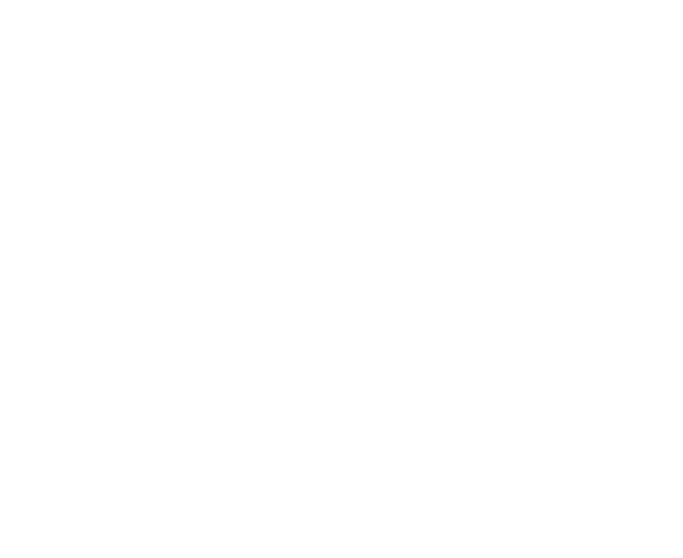

In [25]:
try :
    plt.figure(figsize=(12,10))
    plt.axis('off')
    plt.imshow(plt.imread('runs/train/exp/confusion_matrix.png'));
except :
    pass

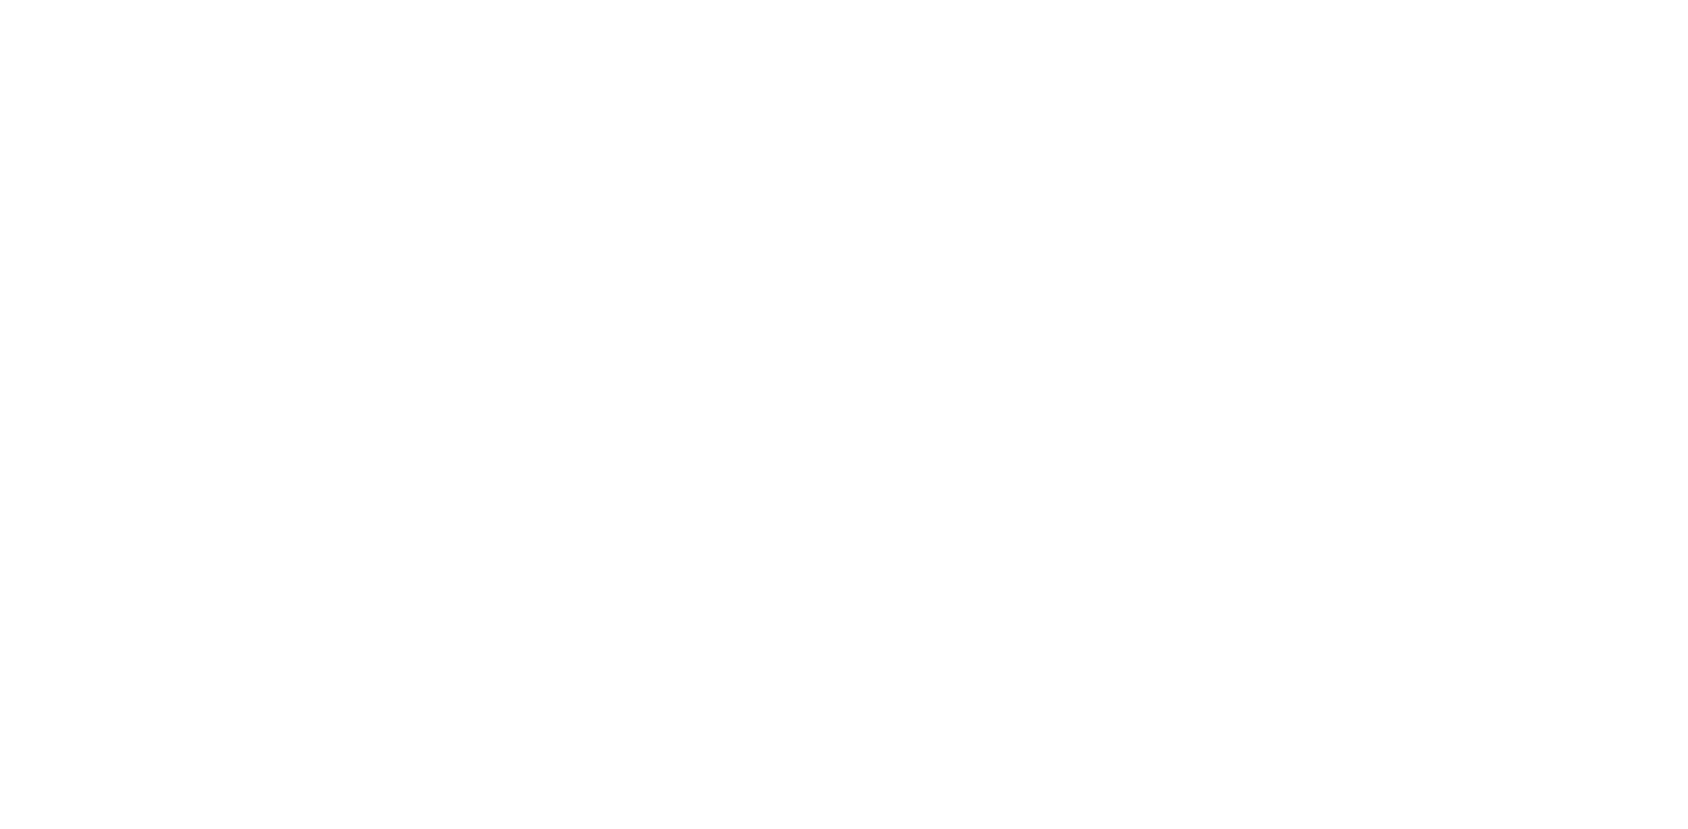

In [26]:
try :
    plt.figure(figsize=(30,15))
    plt.axis('off')
    plt.imshow(plt.imread('runs/train/exp/results.png'));
except :
    pass

## Please Upvote if you find this Helpful

# ✂️ Remove Files

In [27]:
%cd /kaggle/working
!rm -r {IMAGE_DIR}
!rm -r {LABEL_DIR}
!rm -r /kaggle/working/yolov5

/kaggle/working


<img src="https://www.pngall.com/wp-content/uploads/2018/04/Under-Construction-PNG-File.png">